In [43]:
import numpy as np
from scipy import linalg as la
from scipy.linalg import norm
import pywt
from scipy.linalg import solve_triangular
from scipy import sparse
import matplotlib.pyplot as plt

We try to solve the Lasso problem
$$ \min_{b\in \mathbb R^p} \frac{1}{2n} \| y - Xb \|_2^2 + \lambda \| b \|_1 $$

In [44]:
def ista(X, y, lam, L, b0, maxiter=100):
    """ 
    Solve Lasso via ISTA (Iterative Shrinkage-Thresholding Algorithm)
    
    Parameters
    ----------
    X: design matrix, array_like, shape (n, 2)
    y: response vector, array_like, shape (n, )
    lam: regularization parameter, scalar
    L: Lipschitz constant of the quadratic form 
    b0: initialization of the coefficient vector

    Returns
    -------
    B: estimated coefficient vectors, shape (p, maxiter+1), with 1st column b0
    
    """
    b = b0.copy()
    n, p = X.shape
    B = np.zeros((p, maxiter+1))
    B[:,0] = b0
    for i in range(maxiter):
        z = b + 1/(n*L) * X.T @ (y - X@b) # forward(explicit) step
        b = pywt.threshold(z, lam/L, 'soft') # backward(implicit) step
        B[:,i+1] = b
    return B

def fista(X, y, lam, L, b0, maxiter=100):
    """ 
    Solve Lasso via FISTA (Fast Iterative Shrinkage-Thresholding Algorithm)
    
    Parameters
    ----------
    X: design matrix, array_like, shape (n, 2)
    y: response vector, array_like, shape (n, )
    lam: regularization parameter, scalar
    L: Lipschitz constant of the quadratic form 
    b0: initialization of the coefficient vector

    Returns
    -------
    B: estimated coefficient vectors, shape (p, maxiter+1), with 1st column b0
    vec1: 1st off diagonal vector (useful for estimating errors), shape (p*maxiter, )
    vec2: 2nd off diagonal vector (useful for estimating errors), shape (p*maxiter, )
    
    """
    b = b0.copy()
    u = b0.copy()
    n, p = X.shape
    t = 1.0
    B = np.zeros((p, maxiter+1))
    B[:,0] = b0
    vec1 = []
    vec2 = []
    for i in range(maxiter):
        uold = u
        # soft-thresholding 
        u = pywt.threshold(b + 1/(n*L) * X.T @ (y - X@b), lam/L, 'soft')
        told = t
        t = (1 + np.sqrt(1 + 4*t*t)) / 2
        w = (told - 1) / t
        b = u + w * (u - uold)
        B[:,i+1] = b 

        vec1 = np.append(vec1, (1+w)*(u!=0))   # 1st off diagonal
        t_new = (1 + np.sqrt(1 + 4*t*t)) / 2
        w_new = (t - 1) / t_new 
        vec2 = np.append(vec2, -w_new *(u!=0)) # 2nd off diagonal
    return [B, vec1, vec2]

In [45]:
n, p, T = 300, 400, 50
snr = 100

rng = np.random.RandomState()
X = rng.randn(n, p)
b = np.zeros(p); b[:10] = 1
sigma = 0.5
b = b /norm(b) * sigma * snr**(.5)
y = X @ b + sigma * rng.randn(n)

In [46]:
I_p = np.eye(p)
I_T = np.eye(T)

# ISTA
lam = 0.1
L = norm(X, ord=2)**2 / n # Lipschitz constant
b0 = np.zeros(p)
B_hat = ista(X, y, lam, L, b0, maxiter=T-1) # shape (p, T), first column is initialization

# calculate D
D = np.zeros((p*T, p*T))
flag = (np.ravel(B_hat[:,1:].T)!=0) + 0 
D[p:, :(p*(T-1))] = np.diag(flag)
# plt.spy(D, precision=0, markersize=1)
Y = np.array([y] * T).T # replicate response vector y for T times
B_true = np.array([b] * T).T # replicate coefficient vector b for T times
H = B_hat - B_true
F = Y - X @ B_hat

In [47]:
%%time
X1 = I_p - X.T @ X / (n*L)
D_s = sparse.csr_matrix(D)
C = D_s @ sparse.kron(sparse.dia_matrix(I_T), X1)
A1 = np.eye(p*T) - C.toarray()
M = solve_triangular(A1, D, lower=True) / (n*L) # shape (pT, pT)

# faster!!!
N = np.zeros((n*T, n*T))
for t in range(T):
    for t1 in range(T):
        N[t*n:(t+1)*n,t1*n:(t1+1)*n] = X @ M[t*p:(t+1)*p,t1*p:(t1+1)*p] @ X.T
# temp = np.kron(I_T, X)
# N = temp @ M @ temp.T

# interaction matrix: using einsum is much faster!!!
N1 = N.reshape((T, n, T, n))
A = np.einsum('tiTi -> tT', N1)

CPU times: user 4min 52s, sys: 1min 59s, total: 6min 51s
Wall time: 28.1 s


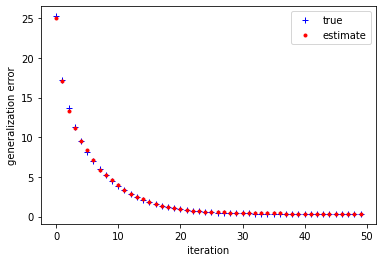

In [48]:
# generalization error
factor = la.inv(I_T - A/n) 
# factor = la.lapack.clapack.dtrtri(I_T - A/n, lower=True)[0] # good for large T
gen = np.diag(H.T @ H + sigma**2 * np.ones((T,T)))
gen_est = np.diag(n**(-1) * factor @ F.T @ F @ factor.T)
plt.xlabel('iteration')
plt.ylabel('generalization error')
plt.plot(range(T), gen,'b+', label='true')
# plt.ylim(0, 60)
plt.plot(range(T), gen_est,'r.', label='estimate')
plt.legend()
plt.show()

In [49]:
[gen[0], gen_est[0], np.sum(y**2)/n]

[25.250000000000004, 25.06255510526121, 25.062555105261207]